how would I code mini-DEG from paper?

Mini-DEG:
1. turn smiles into graph
2. given graph, randomly sample subgraphs
   a. Each sampled subgraph is contracted and becomes a production rule
   b. Contracted node is designated "non-terminal node"
3. last one is contracted into initial node

Reverse process for generation

### Data stuff

In [1]:
from rdkit import Chem
import networkx as nx
import random

In [2]:
# load samples from samples.txt

with open('samples.txt', 'r') as f:
    samples = f.readlines()

samples

['O=C=C=NCN=C=O\n',
 'CC1=C=NC=NCC(=C=O)C=C1\n',
 'O=C=NC1=CC=CC2(C3=CC=C4C=CCCN=CC=C(C=NCC3)C4)CCCCCC(=C1)CC2\n',
 'Cc1cccc(C)c1\n',
 'Cc1ccc(CC2=CC=C(CC3=CCN=CC=C3)CCN=C2)cc1\n',
 'CC(C)(CCCON=C=O)CCOCN=O\n',
 'O=C=NC(N=C=O)=NC1=CC2=CC=NCCC=C=NC(=C=O)C(=CC=C1)C2\n',
 'O=C=NCCC1CCC(N=C=O)CC1\n',
 'CC(N=C=O)C(C)C(=O)C1CCCCCCCC1\n',
 'CC1=CC=CC(C2=CC=C3C=CCCN=C=CC=C(C=C=NCC2)C3)N=C=C1\n']

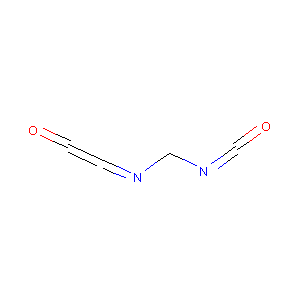

In [3]:
sample = samples[0]
m = Chem.MolFromSmiles(sample)

# display molecule
from rdkit.Chem import Draw
Draw.MolToImage(m)

In [15]:
def mol_to_graph(mol):
    g = nx.Graph()
    for atom in mol.GetAtoms():
        g.add_node(atom.GetIdx(), element=atom.GetSymbol())
    for bond in mol.GetBonds():
        g.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), bond_type=bond.GetBondType())
    return g

def graph_to_mol(g):
    mol = Chem.RWMol()
    for node, data in g.nodes(data=True):
        mol.AddAtom(Chem.Atom(data['element']))
    for u, v, data in g.edges(data=True):
        mol.AddBond(u, v, data['bond_type'])
    Chem.SanitizeMol(mol)
    return mol.GetMol()

{(0, 1): Text(-0.8792652732746946, 0.05667556850384514, 'DOUBLE'),
 (1, 2): Text(-0.6123850830827315, 0.09163413904280211, 'DOUBLE'),
 (2, 3): Text(-0.3085139994774305, 0.0990033234548852, 'DOUBLE'),
 (3, 4): Text(0.007932484808278434, 0.07204943696138166, 'SINGLE'),
 (4, 5): Text(0.3199375419848168, 0.011213426138877693, 'SINGLE'),
 (5, 6): Text(0.6134360652168522, -0.07250992699421556, 'DOUBLE'),
 (6, 7): Text(0.8678417307673084, -0.16689231809760802, 'DOUBLE')}

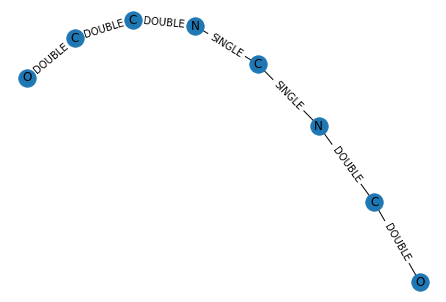

In [30]:
G = mol_to_graph(m)
pos=nx.spring_layout(G)
nx.draw(G, pos, labels={n: d['element'] for n, d in G.nodes(data=True)})
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['bond_type'] for u, v, d in G.edges(data=True)})

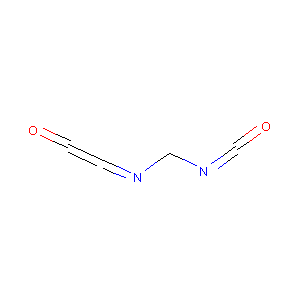

In [33]:
M = graph_to_mol(G)
Draw.MolToImage(M)

### Extract subgraphs

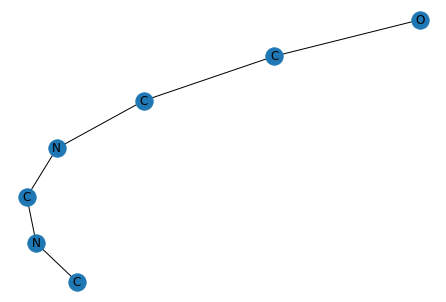

In [34]:
# randomly draw out subgraphs (later on will replace with optimizable edge weights)

def get_subgraph(G):
    while True:
        subgraph = G.subgraph(random.sample(G.nodes(), random.randint(2, len(G.nodes())-1)))
        if nx.is_connected(subgraph):
            return subgraph
    
subgraph = get_subgraph(G)
pos=nx.spring_layout(subgraph)
nx.draw(subgraph, pos, labels={n: d['element'] for n, d in subgraph.nodes(data=True)})

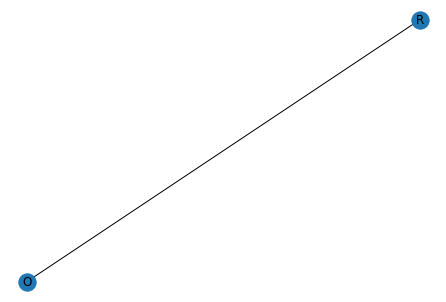

In [35]:
# replace subgraph in graph with non-terminal node

def contract_node(Gc, subgraph):
    
    Gc = G.copy()   
    s_nodes = list(subgraph.nodes())

    # get neighboring edges of subgraph
    neighbors = []
    for node in s_nodes:
        for neighbor in Gc.neighbors(node):
            if neighbor not in s_nodes:
                neighbors.append(neighbor)

    Gc.remove_nodes_from(s_nodes)
    
    # add node in place of subgraph
    idx = max(Gc.nodes()) + 1
    Gc.add_node(idx, element='R')

    # add edges between new node and neighbors of subgraph
    for node in neighbors:
        Gc.add_edge(idx, node, bond_type=Chem.rdchem.BondType.SINGLE)

    return Gc

G = contract_node(G, subgraph)
pos=nx.spring_layout(G)
nx.draw(G, pos, labels={n: d['element'] for n, d in G.nodes(data=True)})

In [72]:
# store production rules in class

class ProductionRule:
    def __init__(self, lhs: nx.Graph, rhs: nx.Graph):
        self.lhs = lhs
        self.rhs = rhs
        
    def __repr__(self):
        return f'{self.lhs.nodes()} -> {self.rhs.nodes()}'

class ProductionRules:
    def __init__(self):
        self.rules = []
        
    def add_rule(self, rule: ProductionRule):
        self.rules.append(rule)
        
    def __repr__(self):
        return f'{self.rules}'
    
    def __len__(self):
        return len(self.rules)

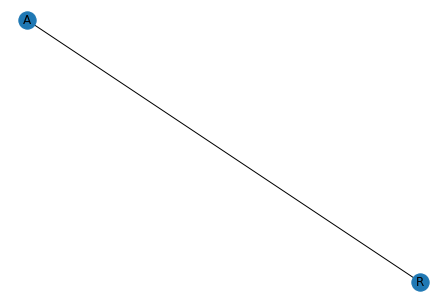

In [62]:
# turn subgraph into production rule

def to_production_rule(subgraph):
    """
    lhs is R and adjacent nodes, rhs is subgraph
    """
    rhs = subgraph
    # rhs = nx.relabel_nodes(subgraph, {n: d['element'] for n, d in subgraph.nodes(data=True)})   # relabel nodes with element, not index

    lhs = nx.Graph()

    r_neighbors = [n for n in G.neighbors(max(G.nodes()))]
    if r_neighbors:
        lhs.add_node(0, element='R')

        for n in G.neighbors(max(G.nodes())):
            if G.nodes[n]['element'] != 'R':
                lhs.add_node(max(lhs.nodes())+1, element='A')   # anchor node
                lhs.add_edge(0, max(lhs.nodes()), bond_type=G.edges[(max(G.nodes()), n)]['bond_type'])
            elif G.nodes[n]['element'] == 'R':
                lhs.add_node(max(lhs.nodes())+1, element='R')
                lhs.add_edge(0, max(lhs.nodes()), bond_type=G.edges[(max(G.nodes()), n)]['bond_type'])
    else:
        lhs.add_node(0, element='X')    # initial node

    return ProductionRule(lhs, rhs)

prod = to_production_rule(subgraph)
pos=nx.spring_layout(prod.lhs)
nx.draw(prod.lhs, pos, labels={n: d['element'] for n, d in prod.lhs.nodes(data=True)})

In [87]:
print(prod.lhs.nodes(data=True))
print(prod.rhs.nodes(data=True))

[(0, {'element': 'R'}), (1, {'element': 'A'})]
[(0, {'element': 'O'}), (1, {'element': 'C'}), (2, {'element': 'C'}), (3, {'element': 'N'}), (4, {'element': 'C'}), (5, {'element': 'N'}), (6, {'element': 'C'})]


In [73]:
# add production rule to production rules

rules = ProductionRules()
rules.add_rule(prod)
len(rules)

1

In [81]:
# apply production rule to generate new graph
# find all production rules that can be applied to graph

valid = []

# compare lhs of production rule to subgraph
for rule in rules.rules:
    for subgraph in [G.subgraph(c) for c in nx.connected_components(G)]:
        if nx.is_isomorphic(subgraph, rule.lhs):
            valid.append((rule, subgraph))
            
# select random valid production rule
rule, subgraph = random.choice(valid)

# apply production rule


[( -> , <networkx.classes.graph.Graph at 0x7f8cc8bd48d0>)]